## Running hyperparameter optimization - Part 1

This notebook goes through part one of the steps and codes for identifying the optimal hyperparameter settings for the Variational Autoencoder framework for integrating multi-omics and clinical data spanning both categorical and continuous variables. <br>

The optimal settings are identified based on multiple steps cosidering both reconstruction on the test and training sets as well as the stability/similiarity of the latent space in case of repeated training. Part one focus on the test and training reconstruction accuracies. The result of the script will be plots for vizualising the comparisons for manual selection of the optimal combination for the use case of the data. Based on these select the top performing settings to run the stability analysis in <i>MOVE_hyperparameter_optimization_stability.ipynb</i>. Before running this make sure you have your data encoded correctly - check <i>encode_data.ipynb</i>.

In [1]:
from hydra import initialize, compose

from move.training.train import optimize_reconstruction
from move.utils.data_utils import get_data, merge_configs
from move.utils.visualization_utils import visualize_likelihood, visualize_recon_acc
from move.utils.analysis import make_and_save_best_reconstruct_params 

Overriding the default config with configs from data.yaml, model.yaml and tuning_reconstruction.yaml

Configuration used: 
---
data:
  user_config: data.yaml
  na_value: 'nan'
  raw_data_path: data/
  interim_data_path: interim_data/
  processed_data_path: processed_data/
  version: v1
  ids_file_name: baseline_ids
  categorical_inputs:
  - name: diabetes_genotypes
    weight: 1
  - name: baseline_drugs
    weight: 1
  - name: baseline_categorical
    weight: 1
  continuous_inputs:
  - name: baseline_continuous
    weight: 2
  - name: baseline_transcriptomics
    weight: 1
  - name: baseline_diet_wearables
    weight: 1
  - name: baseline_proteomic_antibodies
    weight: 1
  - name: baseline_target_metabolomics
    weight: 1
  - name: baseline_untarget_metabolomics
    weight: 1
  - name: baseline_metagenomics
    weight: 1
  data_of_interest: baseline_drugs
  categorical_names: ${names:${data.categorical_inputs}}
  continuous_names: ${names:${data.continuous_inputs}}
  categorical_wei

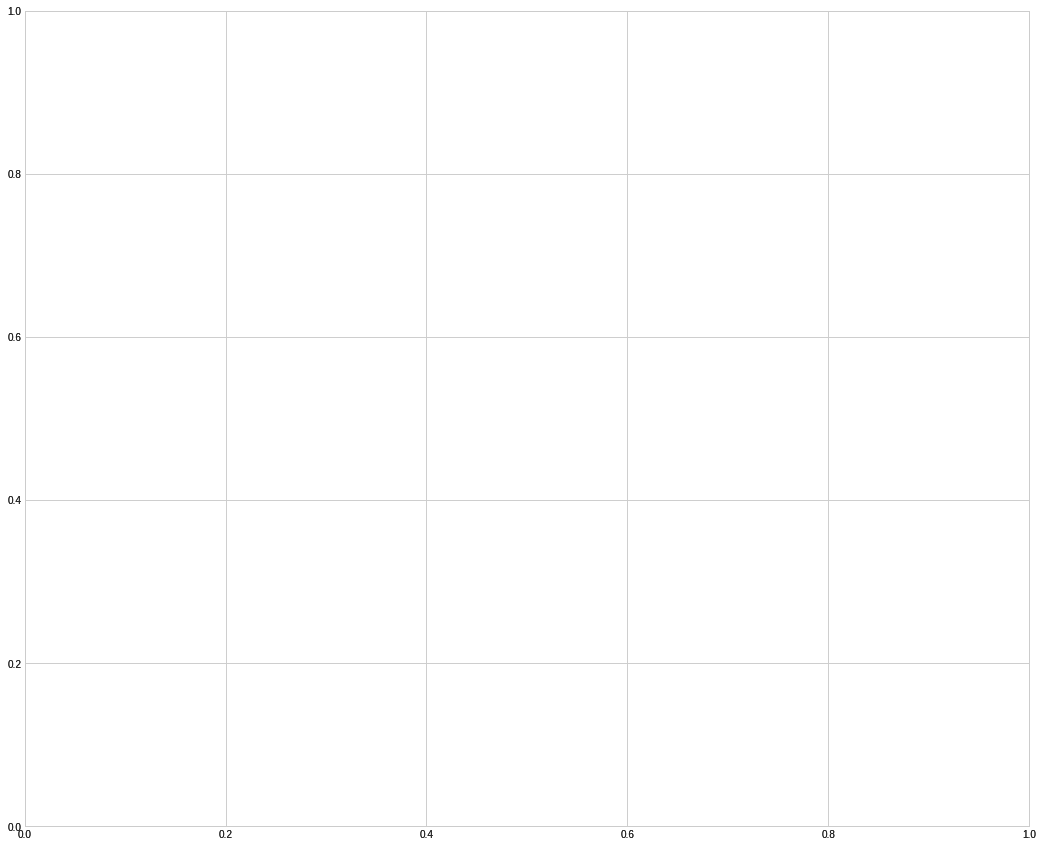

In [2]:
# Initializing the default config 
with initialize(version_base=None, config_path="src/move/conf"):
    base_config = compose(config_name="main")

def main(base_config=base_config): 
    
    # Merging the user defined data.yaml, model.yaml and tuning_reconstruction.yaml 
    # with the base_config to override it.
    print('Overriding the default config with configs from data.yaml, model.yaml and tuning_reconstruction.yaml')
    cfg = merge_configs(base_config=base_config, 
                        config_types=['data', 'model', 'tuning_reconstruction'])
    
    # Getting the variables used in the notebook
    
    raw_data_path = cfg.data.raw_data_path
    interim_data_path = cfg.data.interim_data_path
    processed_data_path = cfg.data.processed_data_path
    data_of_interest = cfg.data.data_of_interest
    categorical_names = cfg.data.categorical_names
    continuous_names = cfg.data.continuous_names
    categorical_weights = cfg.data.categorical_weights
    continuous_weights = cfg.data.continuous_weights
    
    seed = cfg.model.seed
    cuda = cfg.model.cuda
    nepochs = cfg.model.num_epochs
    kld_steps = cfg.model.kld_steps
    batch_steps = cfg.model.batch_steps
    patience = cfg.model.patience
    lrate = cfg.model.lrate
    
    nHiddens = cfg.tuning_reconstruction.num_hidden
    nLatents = cfg.tuning_reconstruction.num_latent
    nLayers = cfg.tuning_reconstruction.num_layers
    nDropout = cfg.tuning_reconstruction.dropout
    nBeta = cfg.tuning_reconstruction.beta
    batch_sizes = cfg.tuning_reconstruction.batch_sizes
    repeat = cfg.tuning_reconstruction.repeats  
    max_param_combos_to_save = cfg.tuning_reconstruction.max_param_combos_to_save
    
    #Getting the data
    cat_list, con_list, cat_names, con_names, headers_all, drug, drug_h = get_data(raw_data_path, interim_data_path, categorical_names, continuous_names, data_of_interest)

    #Performing hyperparameter tuning

    likelihood_tests, recon_acc_tests, recon_acc, results_df = optimize_reconstruction(nHiddens, nLatents, 
                                                                                       nLayers, nDropout, 
                                                                                       nBeta, batch_sizes, 
                                                                                       nepochs, repeat, 
                                                                                       lrate, kld_steps, 
                                                                                       batch_steps, patience, 
                                                                                       cuda, processed_data_path, 
                                                                                       cat_list, con_list,
                                                                                       continuous_weights, 
                                                                                       categorical_weights,
                                                                                       seed)
    

    # Visualizing the data
    try:
        visualize_likelihood(processed_data_path, nLayers, nHiddens, nDropout, nBeta, nLatents, likelihood_tests)
        visualize_recon_acc(processed_data_path, nLayers, nHiddens, nDropout, nBeta, nLatents, recon_acc_tests, 'test')
        visualize_recon_acc(processed_data_path, nLayers, nHiddens, nDropout, nBeta, nLatents, recon_acc, 'train')  
        print('Visualizing the hyperparameter tuning results\n')
    except:
        print('Could not visualize the results\n')

    # Getting and saving the best n hyperparameter set value combinations for further optimisation 
    hyperparams_names = ['num_hidden','num_latent', 'num_layers', 'dropout', 'beta', 'batch_sizes']
    make_and_save_best_reconstruct_params(results_df, hyperparams_names, max_param_combos_to_save)

    return()


if __name__ == "__main__":
    main()

Below are the funcitons for reading data, calculating and saving result defiend

The next part is for reading in the data. This example uses the different datatypes included in the publication of MOVE which consist of three categorical datatypes and seven continuous. NOTE the data is not availble for testing. 

The data is then divided into af 90% training set and a 10% test set to evaluate the hyper-parameters

The dataloader for the two dataset are defined

The hyperparameters tested are defiend below. For this part a selection of fitting values needs to be selected for the specific dataset. The search is here for a full grid search but the code can be modified for sampling if needed. 

Before running the training loop the steps for updating the KLD weight (for KDL warm-up - read paper for more informaiton) as well as increase in batch size is set. The code runs with early stopping in case of increase error on the test set for more than and the epoch with the best result is saved.  

The training loop for the full grid search of hyperparameters

The next part plots the figures for visual evaluation of the performances

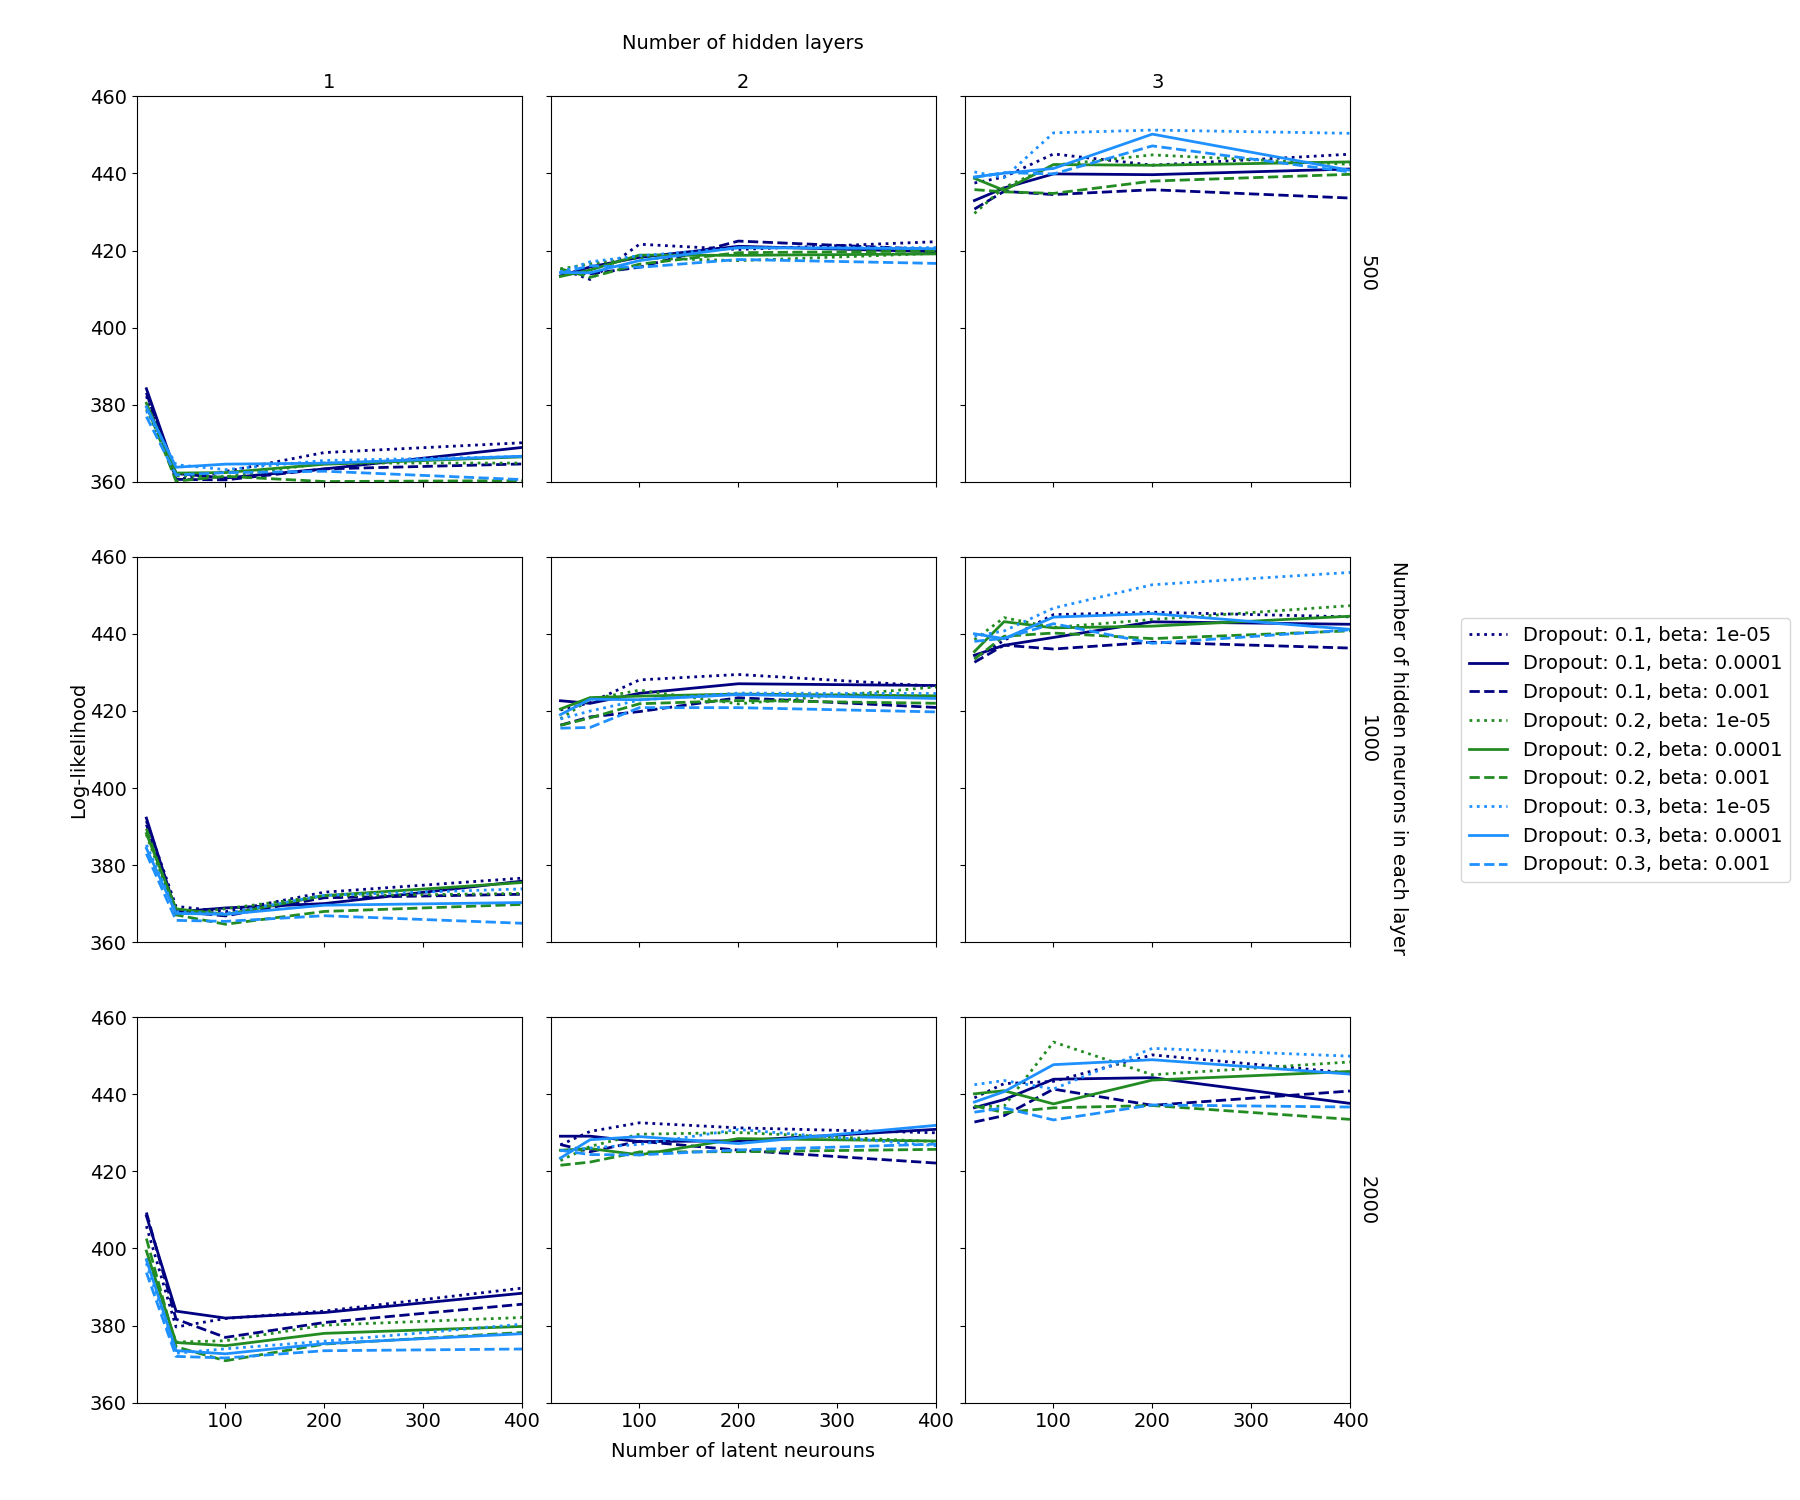

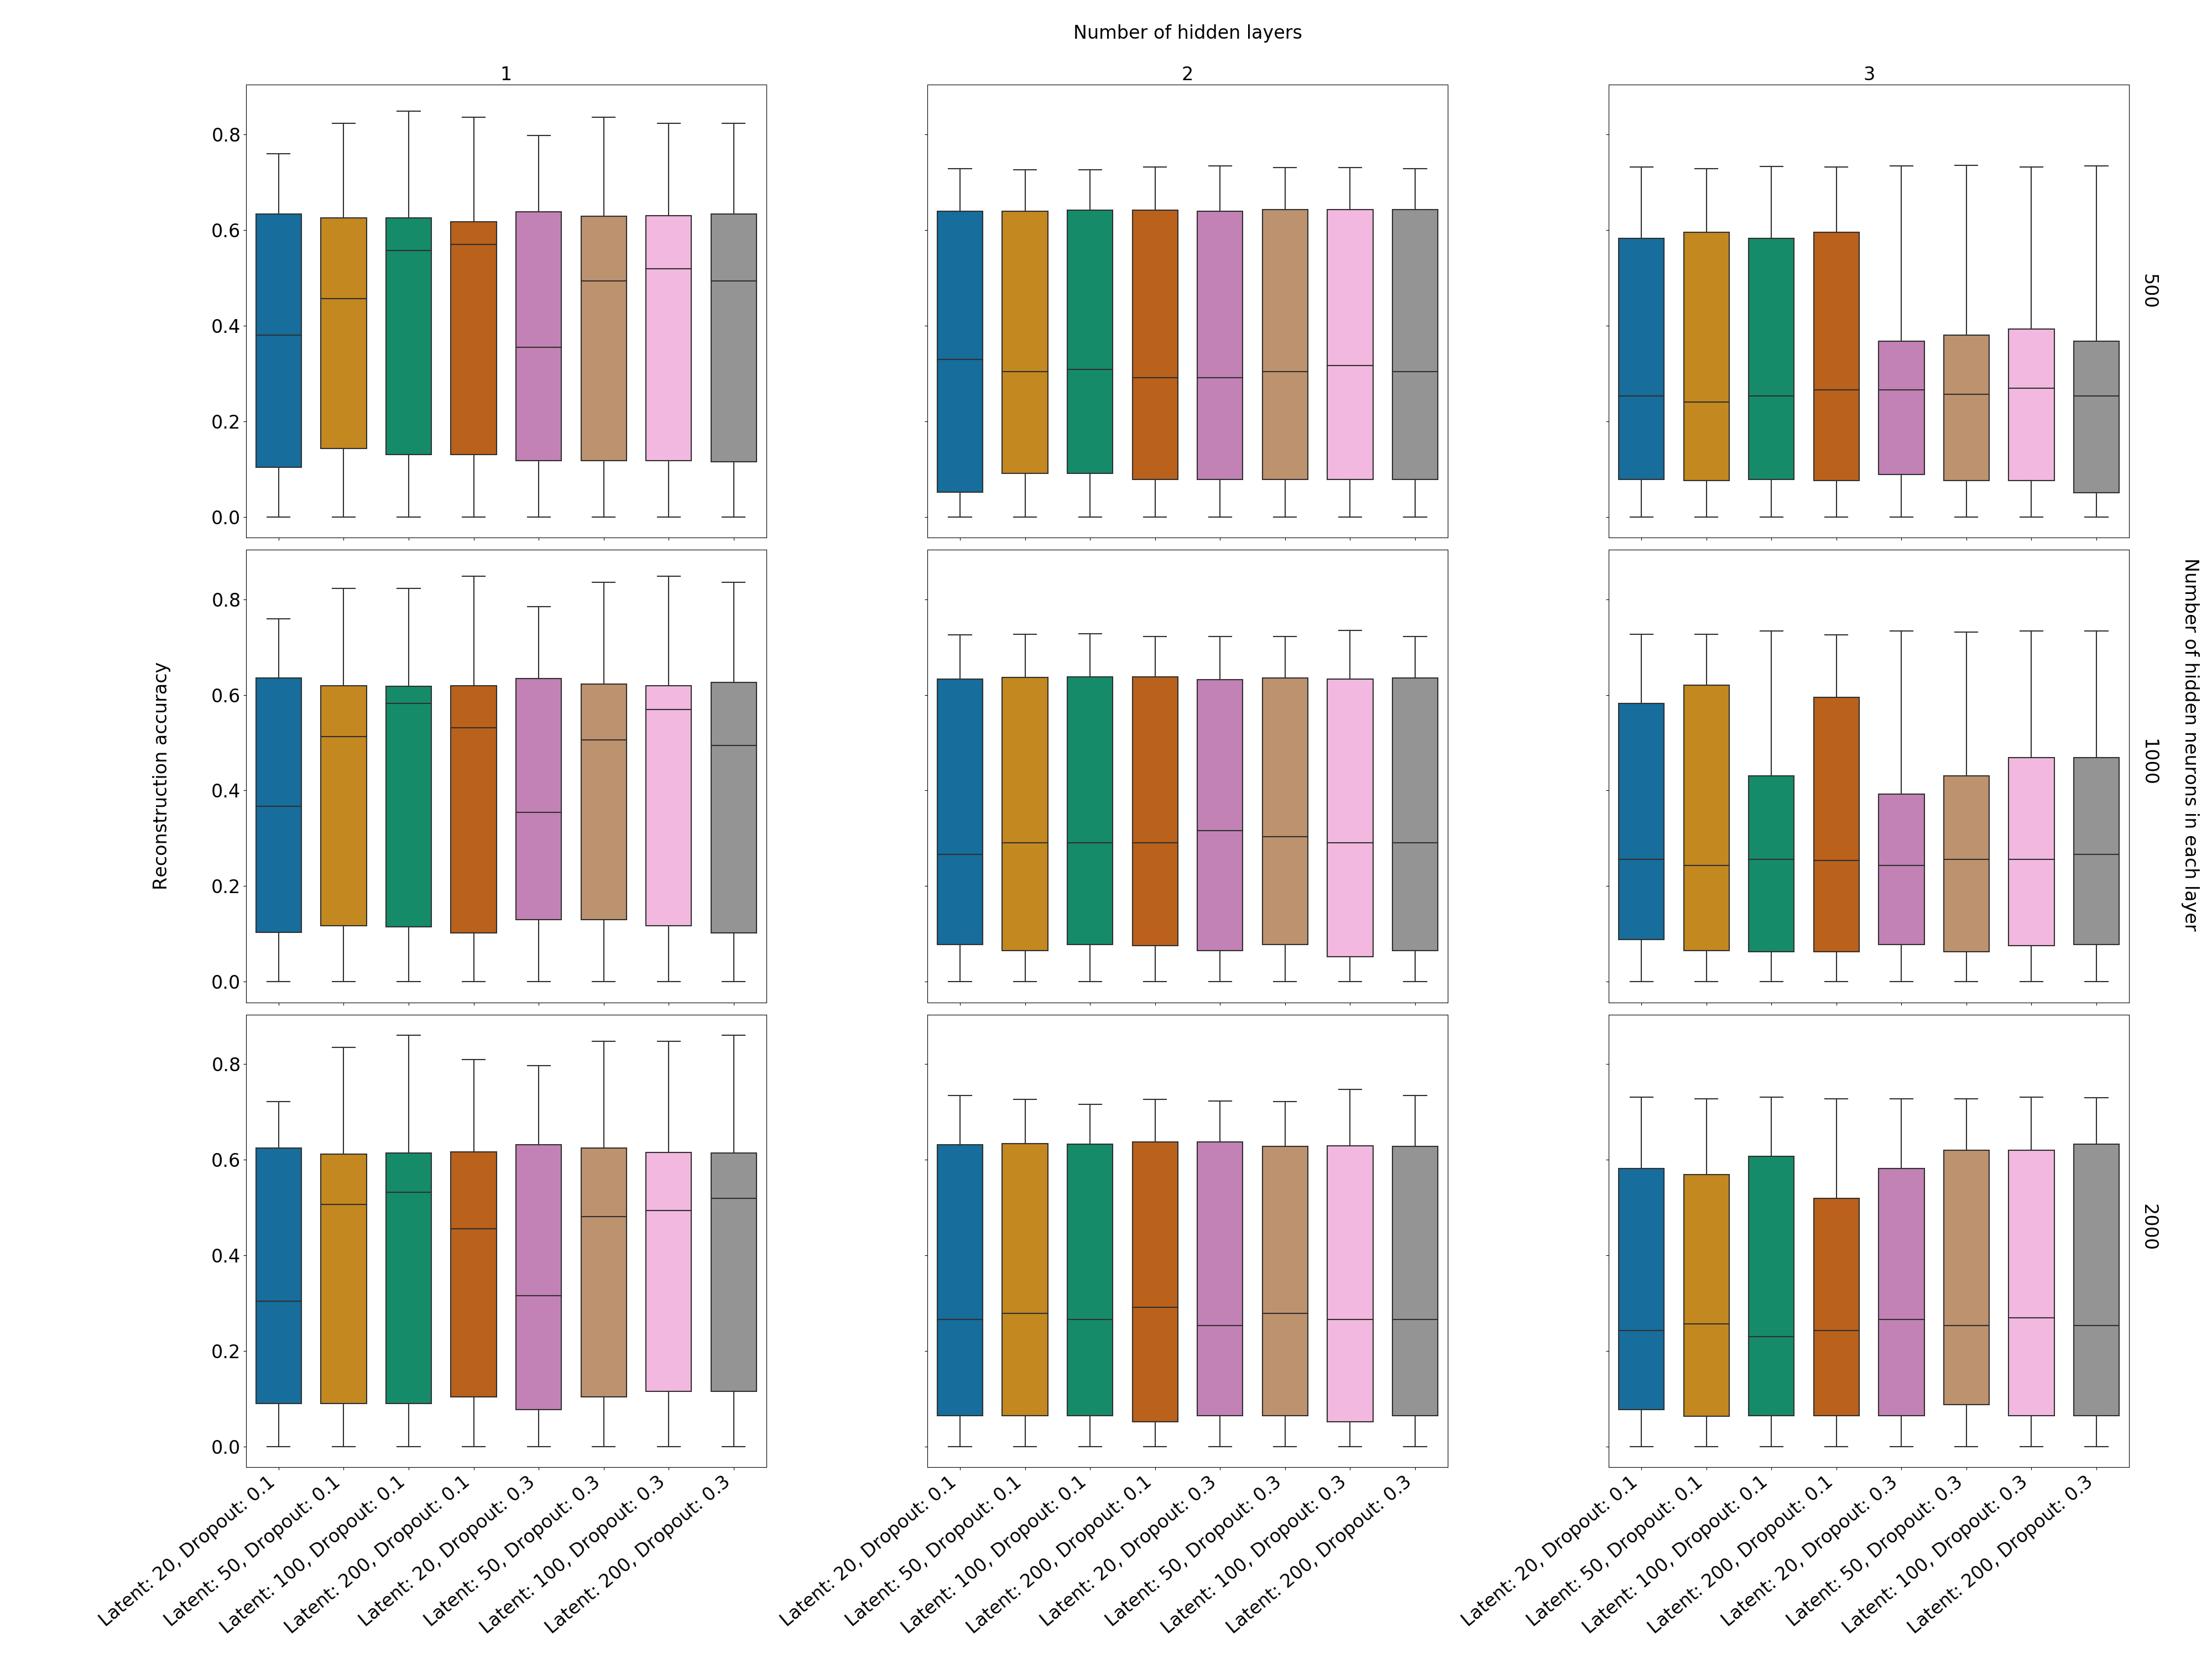

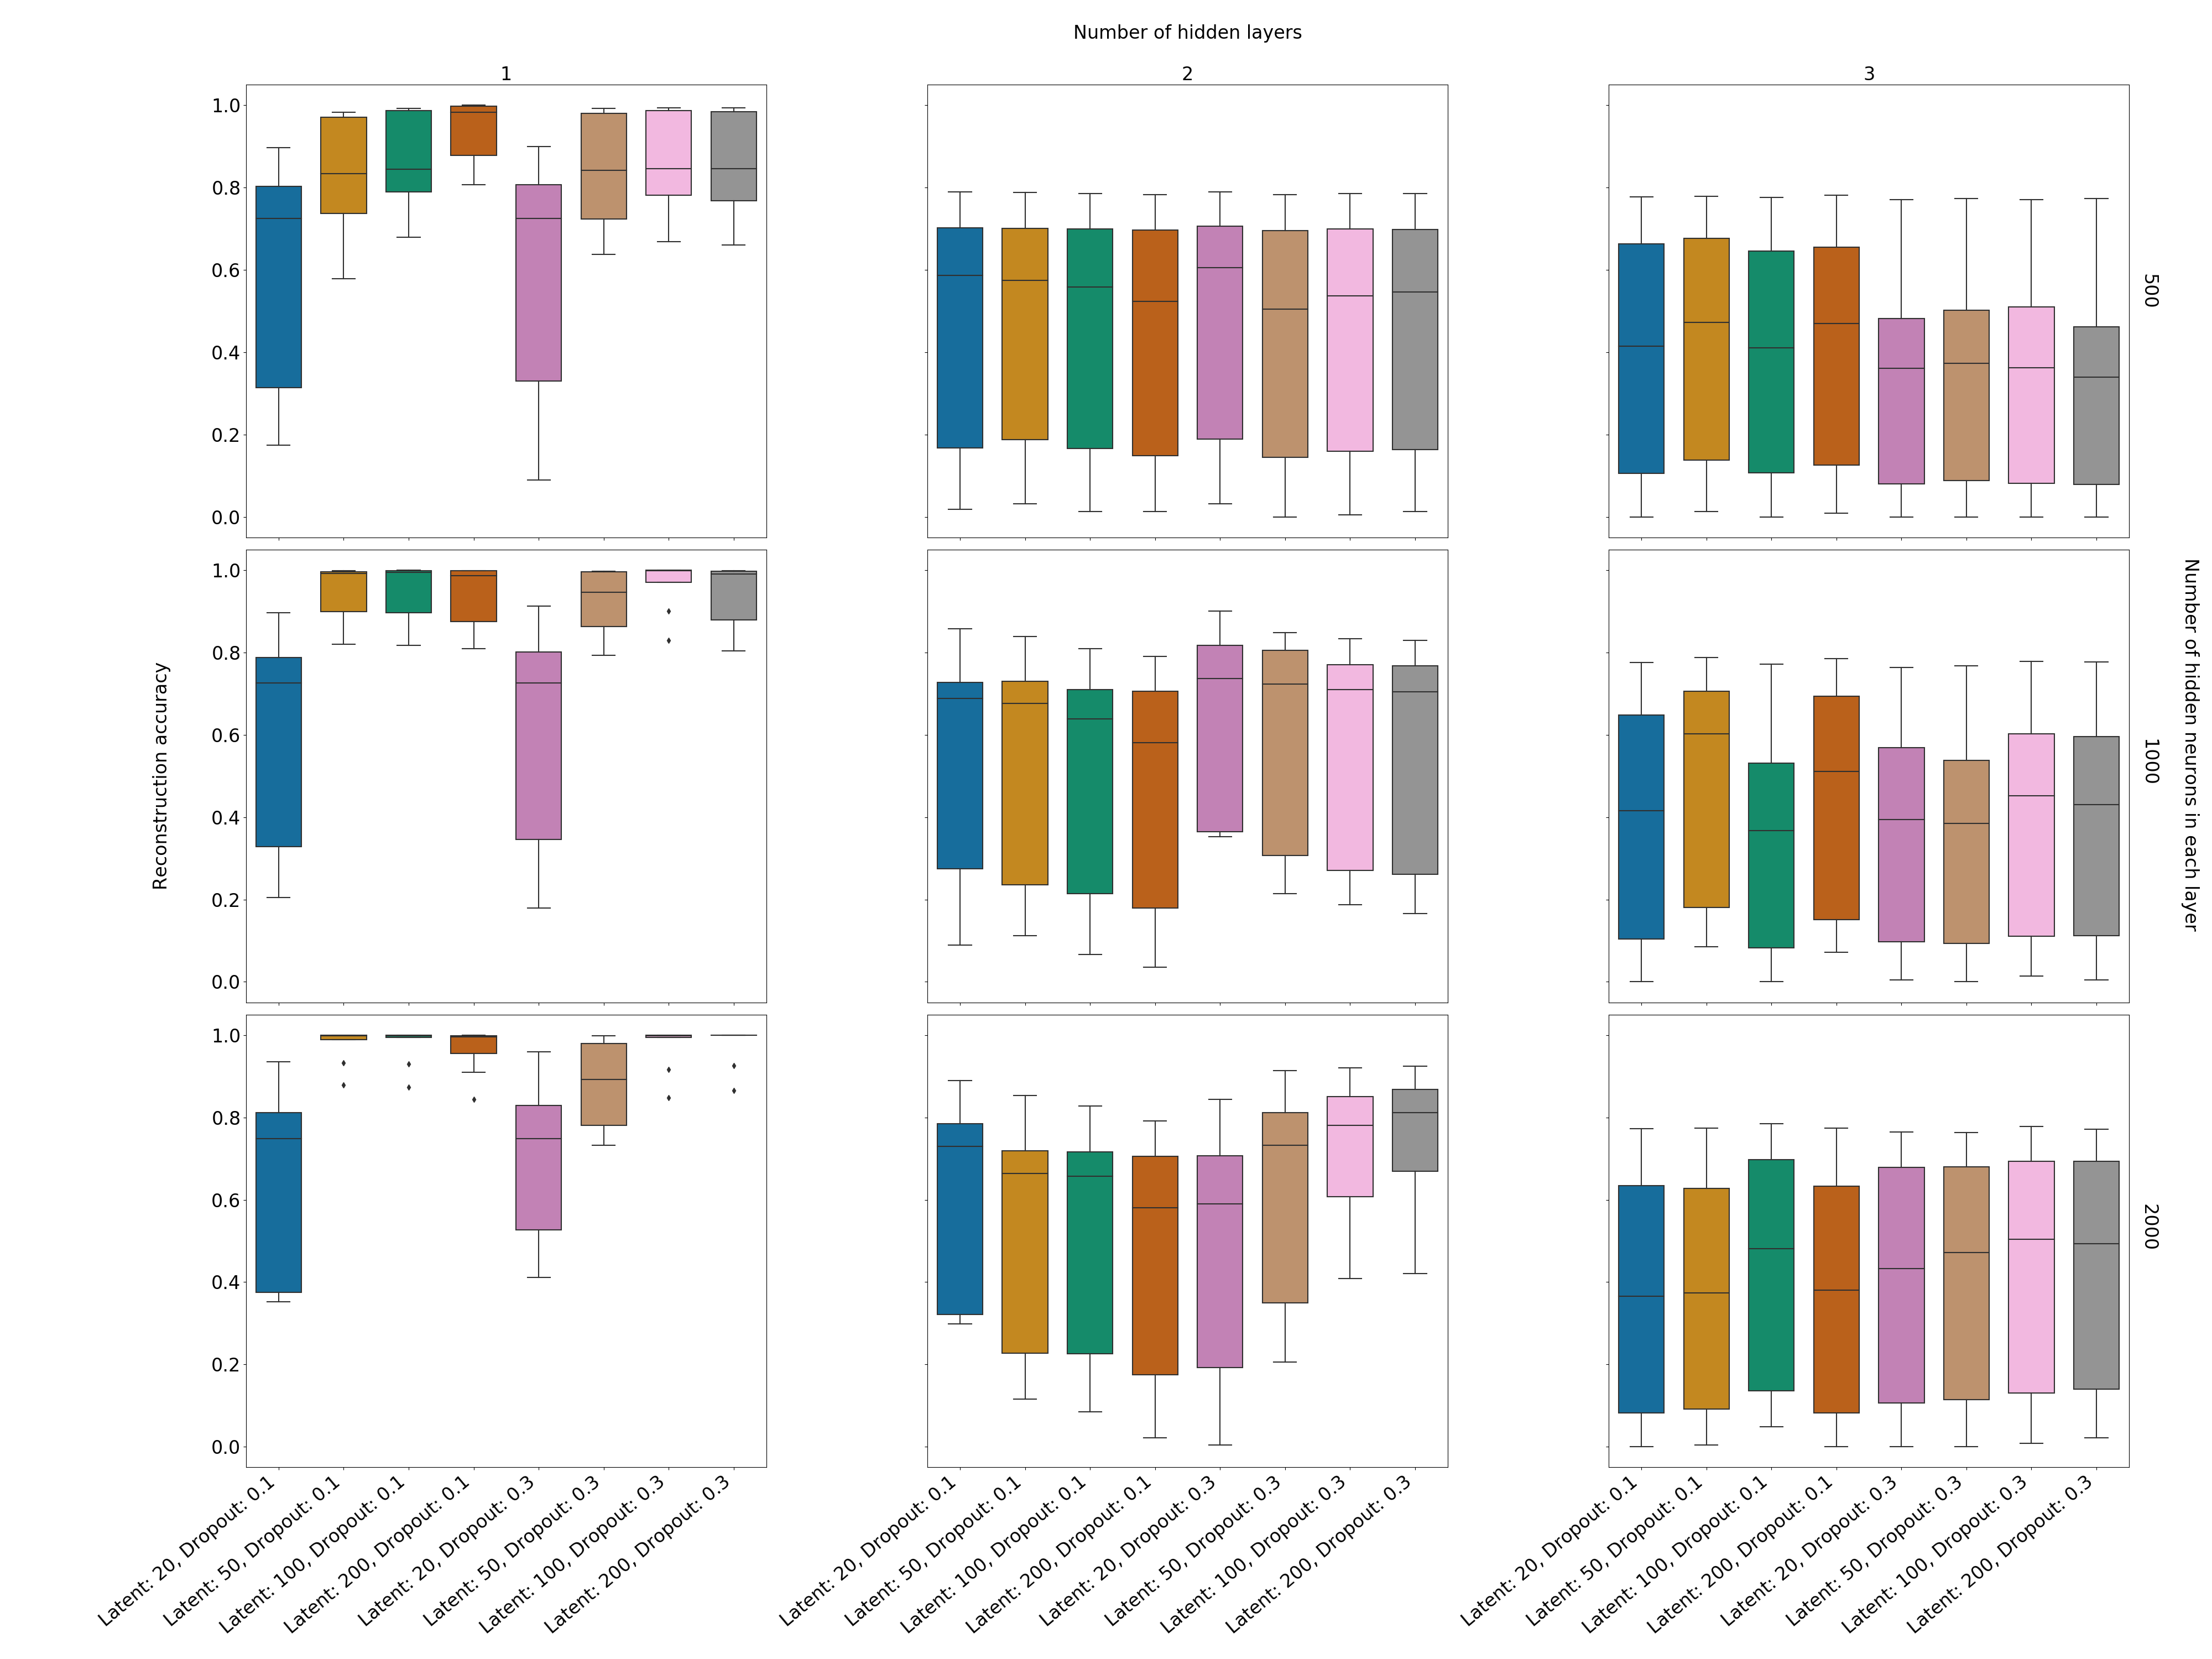

Based on these results we for our method went along with testing the method for stability using one hidden layer, for stablity with repeated training using the code in "<i>VAE_hyperparameter_optimization_stability.ipynb</i>"